# Test model

In [1]:
import os.path
%load_ext autoreload
%autoreload 2

## Import libraries

In [40]:
import torch
from src.unet import UNet
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import os

## Set parameters

In [3]:
model_path = 'models/unet_checkpoint_20250123_172425_epoch100.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Load test data

In [4]:
from src.dataloader_anaglyph_reversed import make_dataloaders
import config_notebook as c

# Make dataloaders
testing_dl = make_dataloaders(path_anaglyph=c.TEST_ANAGLYPH_FILE, path_reversed=c.TEST_REVERSED_FILE)
print(len(testing_dl))

84


In [5]:
first_item = next(iter(testing_dl))
print(first_item['a'].shape)
print(first_item['r'].shape)

torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])


## Load model and set to evaluation mode

In [6]:
model = UNet()
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

/tmp/ipykernel_10303/535969620.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


UNet(
  (encoder1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=T

## Test model with metrics MSE, MAE, PSNR, SSIM

In [7]:
testing_run_timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
print (f"Started testing at {testing_run_timestamp}")

Started testing at 20250123_202041


In [9]:
# Test run to check if everything works
from src.test_model import test_model, set_global_config
import config_notebook_test_run

# Set train config
set_global_config(config_notebook_test_run)

single_item_dl = make_dataloaders(path_anaglyph=c.TEST_ANAGLYPH_FILE, path_reversed=c.TEST_REVERSED_FILE, files_limit=1)

test_model(model=model, test_dl=single_item_dl, device=device, timestamp=testing_run_timestamp)

Header written to ./results/test/testing_losses_unet_20250123_202041.csv


Testing: 100%|██████████| 1/1 [00:00<00:00,  2.87batch/s]

Test results written to ./results/test/testing_losses_unet_20250123_202041.csv


In [10]:
from src.test_model import test_model, set_global_config
import config_notebook

# Set train config
set_global_config(config_notebook)

test_model(model=model, test_dl=testing_dl, device=device, timestamp=testing_run_timestamp)

Header written to ./results/testing_losses_unet_20250123_202041.csv


Testing: 100%|██████████| 84/84 [00:07<00:00, 11.93batch/s]

Test results written to ./results/testing_losses_unet_20250123_202041.csv


## Plot the testing results

In [42]:
import config_notebook as c
# csv_path = os.path.join(c.RESULTS_PATH, f"testing_losses_unet_{testing_run_timestamp}.csv") # To access the results of the test run directly
csv_path = os.path.join(c.RESULTS_PATH, f"testing_losses_unet_20250123_202041.csv") # To access other test runs (plot results without the need of a test run)

# Read the CSV file
df = pd.read_csv(csv_path)

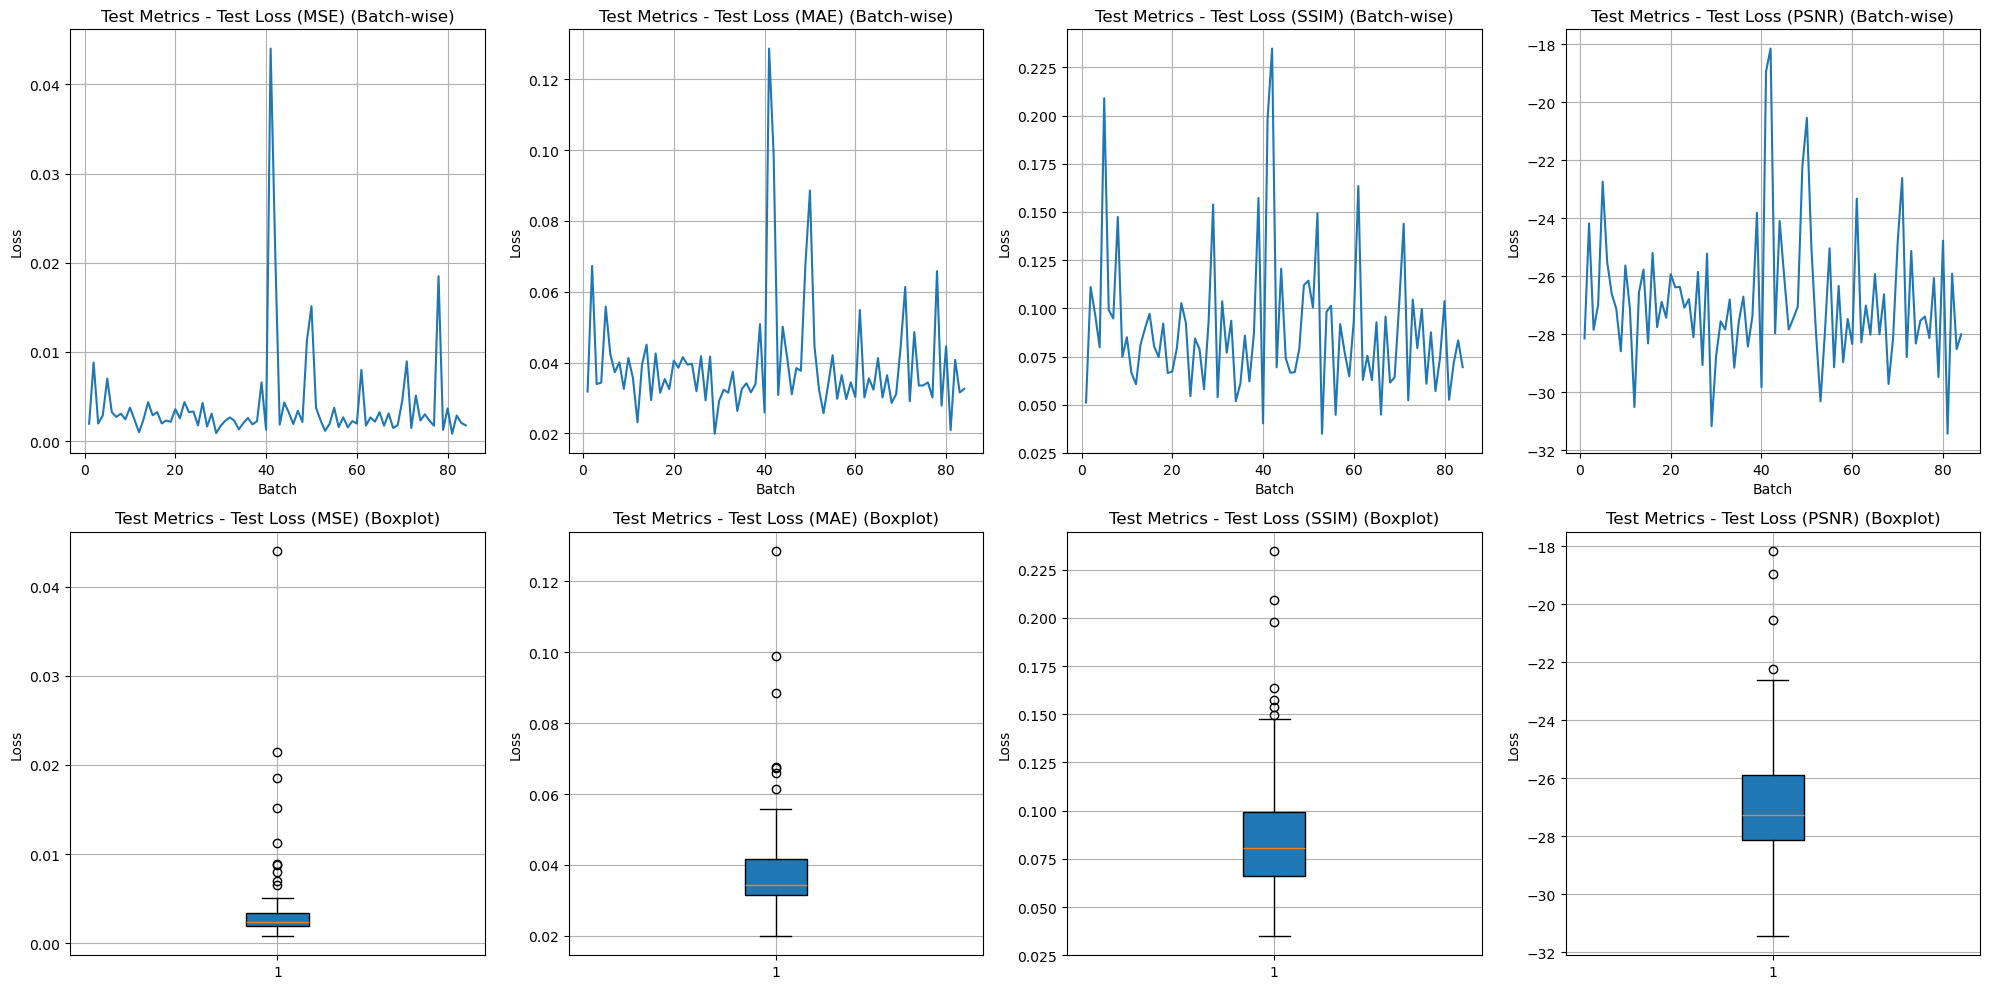

In [47]:
# Plot all metrics for each batch in a 2x4 grid
metrics = df.columns[1:]  # Skip the 'Batch' column
num_metrics = len(metrics)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, metric in enumerate(metrics):
    # Plot batch-wise metrics in the first row
    axes[0, i].plot(df['Batch'], df[metric])
    axes[0, i].set_xlabel('Batch')
    axes[0, i].set_ylabel('Loss')
    axes[0, i].set_title(f'Test Metrics - {metric} (Batch-wise)')
    axes[0, i].grid(True)

    # Plot boxplots in the second row
    axes[1, i].boxplot(df[metric], vert=True, patch_artist=True)
    axes[1, i].set_ylabel('Loss')
    axes[1, i].set_title(f'Test Metrics - {metric} (Boxplot)')
    axes[1, i].grid(True)

plt.tight_layout()
plt.show()
